# "LOO-PIT tutorial"
> Extend your posterior predictive checks with leave one out probability integral transform

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [python, arviz, pymc3]
- tags: [visualization, model criticism]
- image: images/nb/loo_pit_bias.png
- use_math: true

## Introduction

One of the new functionalities I added in ArviZ during my GSoC internship is Leave One Out (LOO) Probability Integral Transform (PIT) marginal posterior predictive checks. You can see [two](https://arviz-devs.github.io/arviz/examples/plot_loo_pit_ecdf.html) [examples](https://arviz-devs.github.io/arviz/examples/plot_loo_pit_overlay.html) of its usage in the example gallery and also some examples in its [API section](https://arviz-devs.github.io/arviz/generated/arviz.plot_loo_pit.html#arviz.plot_loo_pit). However, these examples are mainly related to the usage of the functionalities, not so much on the usage of LOO-PIT itself nor its interpretability.

I feel that the LOO-PIT algorithm usage and interpretability needs a short summary with examples showing the most common issues found when checking models with LOO-PIT. This tutorial will tackle this issue: how can LOO-PIT be used for model checking and what does it tell us in a practical manner, so we can see firsthand how wrongly specified models cause LOO-PIT values to differ from a uniform distribution. I have included a short description on what is the algorithm doing, however, for a detailed explanation, see:

* Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., and Rubin, D. B. (2013). Bayesian Data Analysis. Chapman & Hall/CRC Press, London, third edition. (p. 152-153)

We will use LOO-PIT checks along with non-marginal posterior predictive checks as implemented in ArviZ. This will allow to see some differences between the two kinds of posterior predictive checks as well as to provide some intuition to cases where one may be best and cases where both are needed.

Here, we will experiment with LOO-PIT using two different models. First an estimation of the mean and standard deviation of a 1D Gaussian Random Variable, and then a 1D linear regression. Afterwards, we will see how to use LOO-PIT checks with multivariate data using as example a multivariate linear regression.

## Background

One of the pilars of Bayesian Statistics is working with the posterior distribution of the parameters instead of using point estimates and errors or confidence intervals. We all know how to obtain this posterior given the likelihood, the prior and the , $p(\theta \mid y) = p(y \mid \theta) p(\theta) / p(y)$. In addition, in many cases we are also interested in **the probability of future observations given the observed data** according to our model. This is called posterior predictive, which is calculated integrating out $\theta$:

$$ p(y^* | y) = \int p(y^*|\theta) p(\theta|y) d\theta$$

where $y^*$ is the possible unobserved data and $y$ is the observed data. Therefore, if our model is correct, the observed data and the posterior predictive follow the same probability density function (pdf). In order to check if this holds, it is common to perform posterior predictive checks comparing the posterior predictive to the observed data. This can be done directly, comparing the kernel density estimates (KDE) of the observed data and posterior predictive samples, etc. A KDEs is nothing else than an estimation of the pdf of a random variable given a finite number of samples from this random variable.

Another alternative it to perform LOO-PIT checks, which are a kind of marginal posterior predictive checks. Marginal because we compare each observation only with the corresponding posterior predictive samples instead of combining all observations and all posterior predictive samples. As the name indicates, it combines two different concepts, Leave-One-Out Cross-Validation and Probability Integral Transform.

### Probability Integral Transform

Probability Integral Transform stands for the fact that given a random variable $X$, **the random variable $Y = F_X(X) = P(x \leq X)$ is a uniform random variable if the transformation $F_X$ is the Cumulative Density Function** (CDF) of the original random variable $X$. 

If instead of $F_X$ we have $n$ samples from $X$, $\{x_1, \dots, x_n\}$, we can use them to estimate $\hat{F_X}$ and apply it to future $X$ samples ${x^*}$. In this case, $\hat{F_X}(x^*)$ will be approximately a uniform random variable, converging to an exact uniform variable as $n$ tends to infinity.

The mathematical demonstration can be found on wikipedia itself just googling it. However here, instead of reproducing it I will try to outline the intuition behind this fact. One way to imagine it is with posterior samples from an MCMC run. If we have enough samples, the probability of a new sample falling between the two smallest values will be the same than the probability of a new sample falling inside the two values closest to the median. 

This is because around the probability around the smallest values will be lower, but they will be further apart, whereas the probability around the median will be larger but they will be extremely close. These two effect compensate each other and the probability is indeed the same. Thus, the probability is constant independently of the square the new sample would fall in, which is only compatible with a uniform distribution.

### Leave-One-Out Cross-Validation

Cross-Validation is one way to try to solve the problem with all the *future data* I have been mentioning so far. We do not have this future data, so how are we supposed to make calculations with it? Cross-Validation solves this problem by dividing the observed data in $K$ subsets, excluding one subset from the data used to fit the model (so it is data unknown to the model, aka future data) and then using this excluded subset as future data. In general, to get better results, this process is preformed $K$ times, excluding one different subset every time.

LOO-CV is one particular case where the number of subsets is equal to the number of observations so that each iteration only one observation is excluded. That is, we **fit the model one time per observation excluding only this one observation**.

### LOO-PIT

LOO-PIT checks consist on checking the PIT using LOO-CV. That is, fit the model on all data but observation $y_i$ (we will refer to this leave one out subset as $y_{-i}$), use this model to estimate the cumulative density function of the posterior predictive and calculate the PIT, $P(y_i < y^* \mid y_{-i}) = \int_{-\infty}^{y_i} p(y^* \mid y_{-i}) dy^*$, of each observation. Then, the KDE of all LOO-PIT values is estimated to see whether or not it is compatible with the LOO-PIT values being draws from a uniform variable.

## Data generation

In [1]:
import pymc3 as pm
import numpy as np
import arviz as az 
import matplotlib.pyplot as plt
import theano.tensor as tt

import scipy.stats as stats

np.random.seed(7)

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="obs", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

In [4]:
N_obs = 170
mu_normal = -2
sd_normal = 3
data_normal = np.random.normal(loc=mu_normal, scale=sd_normal, size=N_obs)
a0_lr, a1_lr = 5, -2.3
sd_lr = 1.4
data_x_regression = np.linspace(0, 10, N_obs)
data_y_regression = np.random.normal(loc=a1_lr*data_x_regression+a0_lr, scale=sd_lr)

In [5]:
coords_normal = {"obs": ["observation"], "log_likelihood": ["observation"]}
dims_normal = {"observation": range(N_obs)}
coords_regression = {"y": ["time"], "log_likelihood": ["time"]}
dims_regression = {"time": data_x_regression}

We will now plot the two datsets generated, to give graphical an idea of the data we are working with.

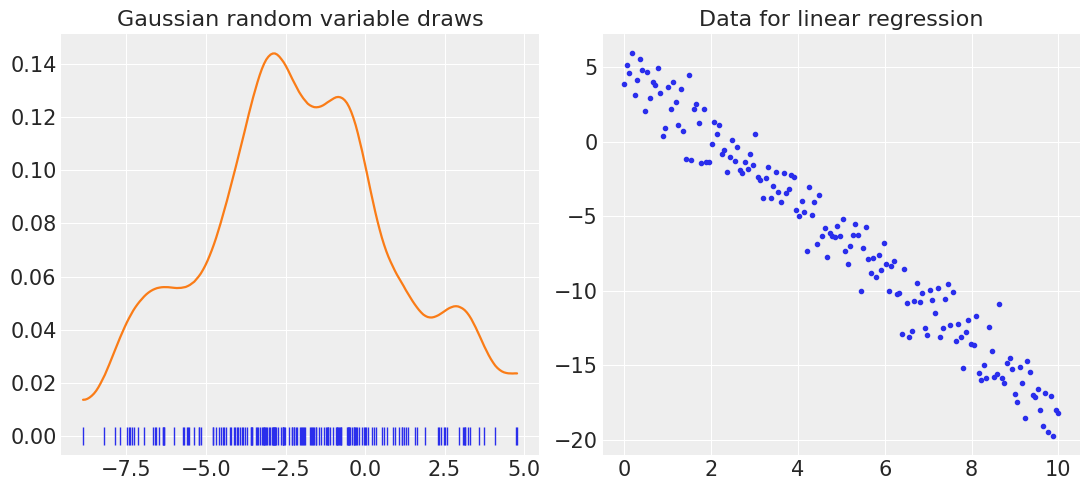

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
textsize = plt.rcParams["axes.labelsize"]
az.plot_dist(data_normal, rug=True, ax=axes[0], rug_kwargs={"space": 0}, textsize=textsize);
axes[1].plot(data_x_regression, data_y_regression, ".");
axes[1].tick_params(labelsize=textsize)
axes[0].set_title("Gaussian random variable draws")
axes[1].set_title("Data for linear regression")
fig.tight_layout()

## Unidimensional Gaussian variable
We will start with a model that correctly fits with the data, to show how should both checks look like. Afterwards, we will see cases were these checks deviate from this ideal case and give some hints on how to interpret these deviations.

In [7]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    sd = pm.HalfNormal("sd", sd=10)
    
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, sd=sd, observed=data_normal)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    idata_normal = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_normal,
        dims=dims_normal,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1748.53it/s]


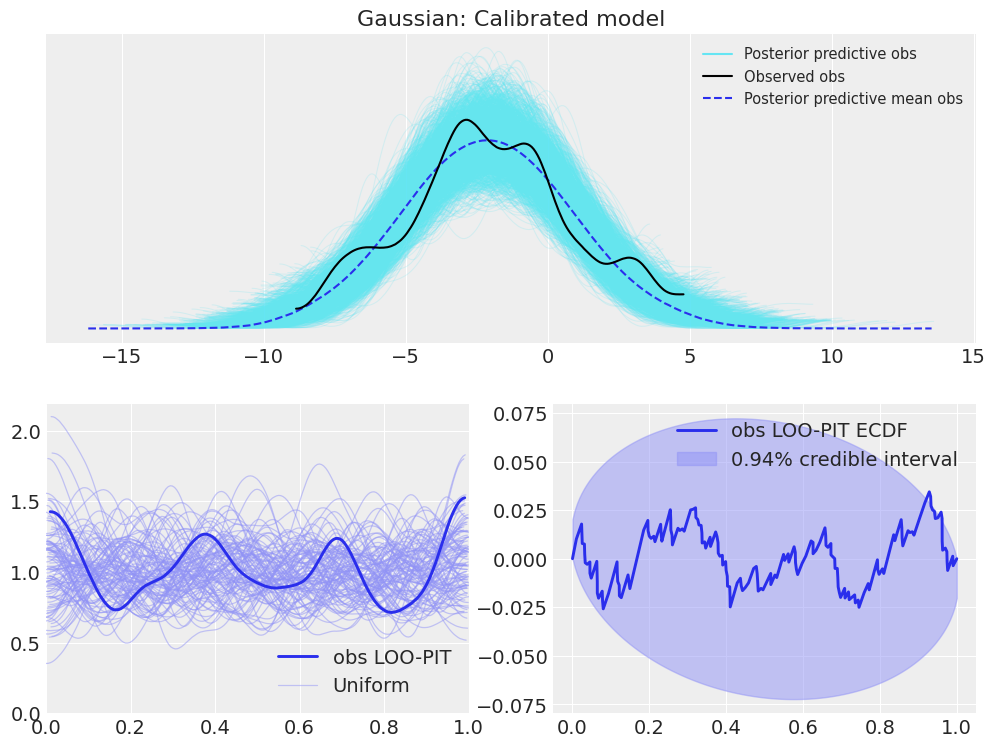

In [8]:
plot_ppc_loopit(idata_normal, "Gaussian: Calibrated model");

To begin with, it can be seen that **the observed KDE is similar to the overlayed posterior predictive KDEs**. The **same happens with the LOO-PIT values**; the LOO-PIT KDE is similar to the overlayed uniform KDEs. Thus, in this first example, similar information can be obteined from their interpretation.

### Overdispersion signs
We will now move to one common mismatch between the model and the observed data. We will perform the same fit as the previous example but fixing the standard deviation of the normal random variable. This is actually not an unrealistic case, as in many cases where the instrument used to measure gives error data in addition to the measure, this error is used to fix the standard deviation.

These two examples show how the LOO-PIT looks like for overdispersed models (i.e. the error is assumed to be larger than what it actually is) and for underdispersed models (i.e. the error is assumed to be smaller than what it really is).

In [9]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sd=10)
    
    likelihood = pm.Normal("obs", mu=mu, sd=1.5 * sd_normal, observed=data_normal)
    
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    idata_normal_overdispersed = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_normal,
        dims=dims_normal,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 3299.82it/s]


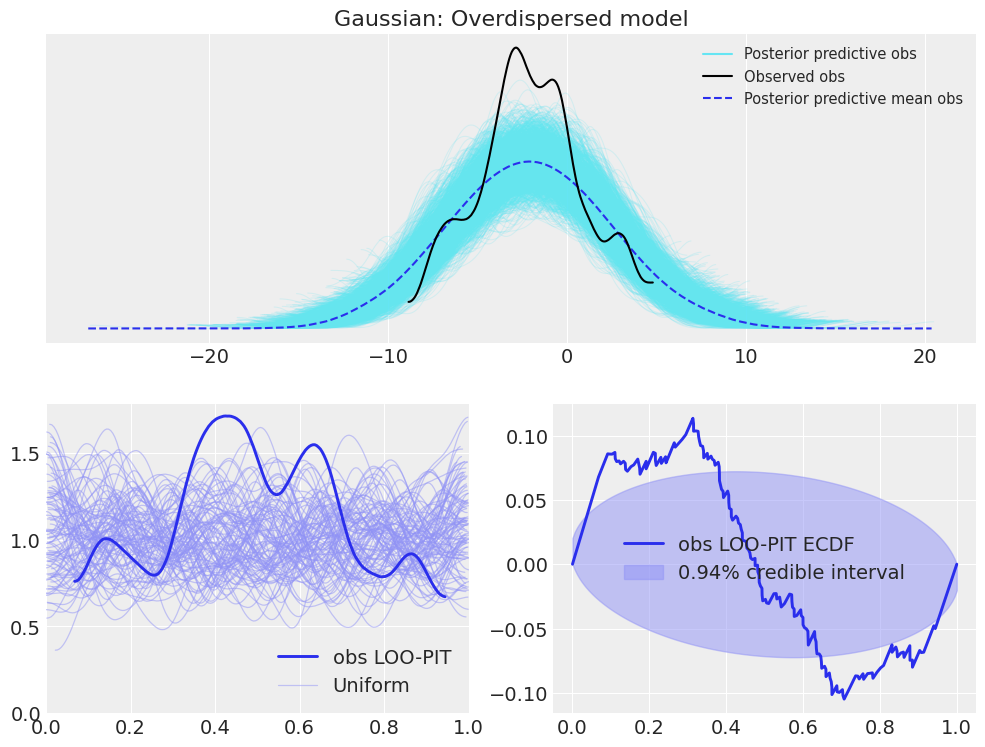

In [10]:
plot_ppc_loopit(idata_normal_overdispersed, "Gaussian: Overdispersed model");

In this example of **overdispersed model**, we can see that the posterior predictive checks show that the **observed KDE is narrower than most of the posterior predictive KDEs** and narrower than the mean KDE of the posterior predictive samples. However, there are still some posterior predictive samples whose KDEs are similar to the observed KDE. In the LOO-PIT check though, there is no room for confursion. **The LOO-PIT KDE is not uniform between 0 and 1**, its range is much quite more limited than the uniform counterparts. Moreover, the difference between the Empirical Cumulative Density Function (ECDF) and the ideal uniform CDF lays outside the envelope most of the time.

### Underdispersion signs

In [11]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sd=10)
    
    likelihood = pm.Normal("obs", mu=mu, sd=.75 * sd_normal, observed=data_normal)
    
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    idata_normal_underdispersed = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_normal,
        dims=dims_normal,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 3354.84it/s]


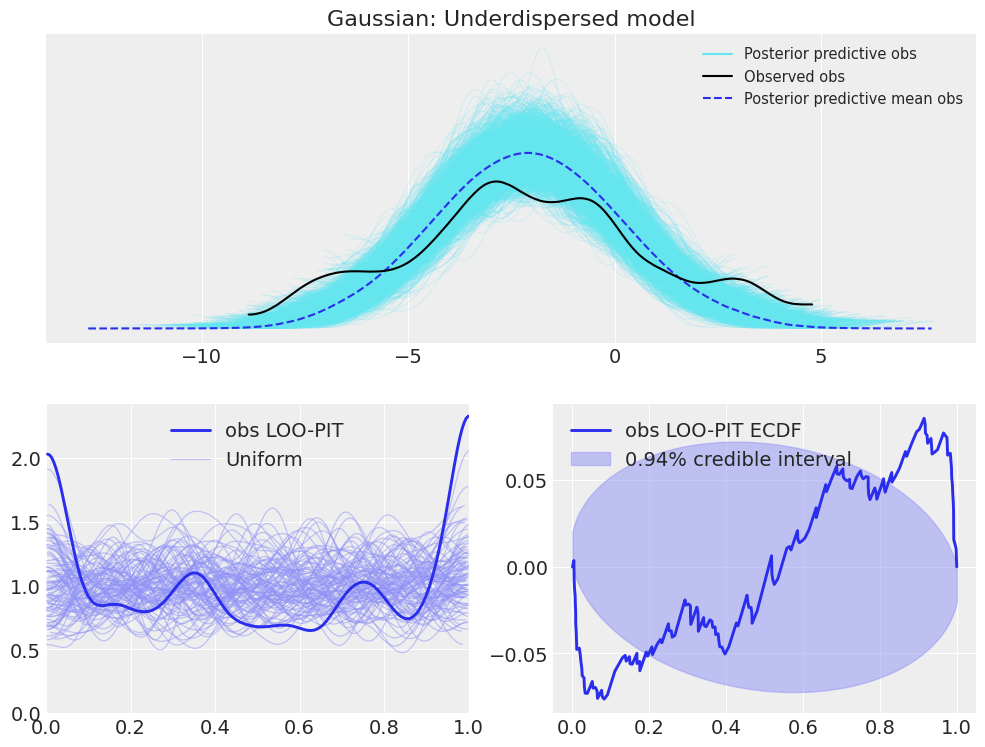

In [12]:
plot_ppc_loopit(idata_normal_underdispersed, "Gaussian: Underdispersed model");

Here, the differences are similar to the overdispersed case, modifying overdispersed by underdispersed and inverting the shapes.

### Bias signs

In addition, LOO-PIT checks also show signs of model bias, as shown in the following example:

In [13]:
with pm.Model() as model:
    sd = pm.HalfNormal("sd", sd=10)
    
    likelihood = pm.Normal("obs", mu=mu_normal - sd_normal / 2, sd=sd, observed=data_normal)
    
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    idata_normal_bias = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_normal,
        dims=dims_normal,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd]
100%|██████████| 2000/2000 [00:01<00:00, 1613.28it/s]


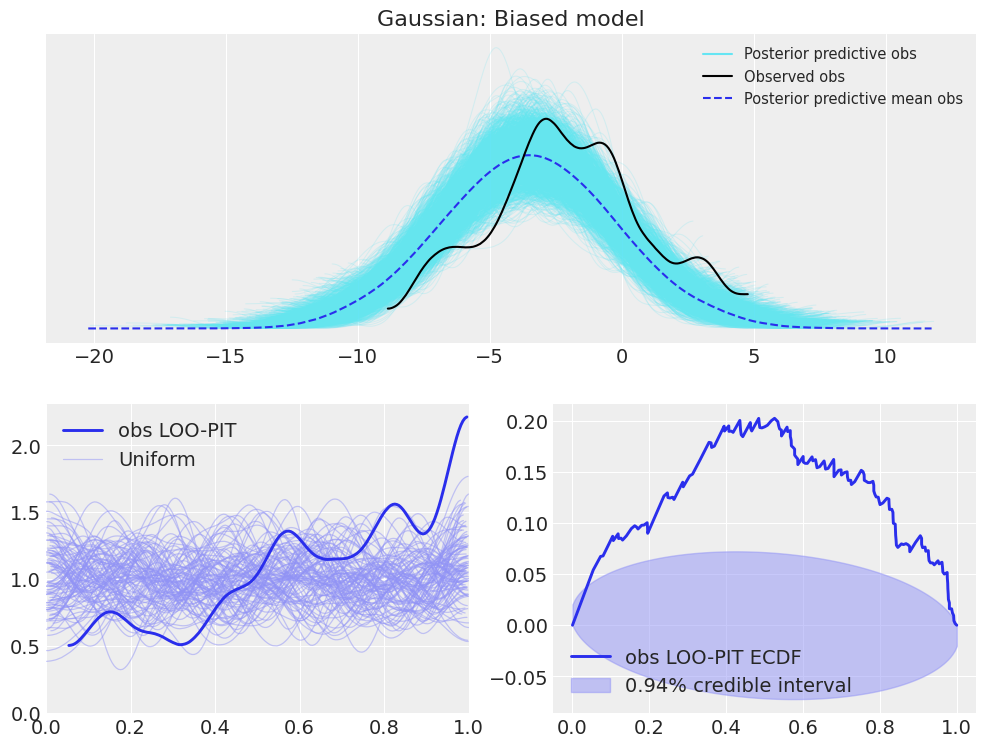

In [14]:
plot_ppc_loopit(idata_normal_bias, "Gaussian: Biased model");

It is important to note though, that the LOO-PIT itself already indicates the problem with the model: 
* a convex KDE shape (inverted-U shape or range smaller than 0-1) or an N in the ECDF difference plot is a sign of an overdispersed model
* a concave KDE shape (U shape) or an inverted-N ECDF difference is a sign of underdispersion
* an asymmetrical KDE (range may also be reduced instead of 0-1) or ECDF difference is a sign for model bias

In general though, we will probably find a combination of all these cases and it may not be straigthforward to interpretate what is wrong with the model using LOO-PIT or posterior predictive KDE checks.

## Linear regression
In the case of a linear regression, the posterior predictive checks direclty do not give us much information, because each datapoint is centered at a different location, so combining them to create a single KDE won't yield useful results. 
It is important to note though, that this is not an issue inherent to the posterior predictive checks, and could be solved by rescaling each observation by substracting the mean and divide by the standard deviation along every observation from the posterior predictive. We will also include an example of this kind of transformation in the last example, but there should not be much to worry about as this improvement is on the ArviZ roadmap.

In [15]:
with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', sd=10)
    a0 = pm.Normal("a0", mu=0, sd=20)
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    likelihood = pm.Normal('obs', mu=a0 + a1 * data_x_regression, sd=sigma, observed=data_y_regression)
    
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    idata_lr = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_regression,
        dims=dims_regression,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a0, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2882.58draws/s]
The acceptance probability does not match the target. It is 0.9065348582364419, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:01<00:00, 1221.16it/s]


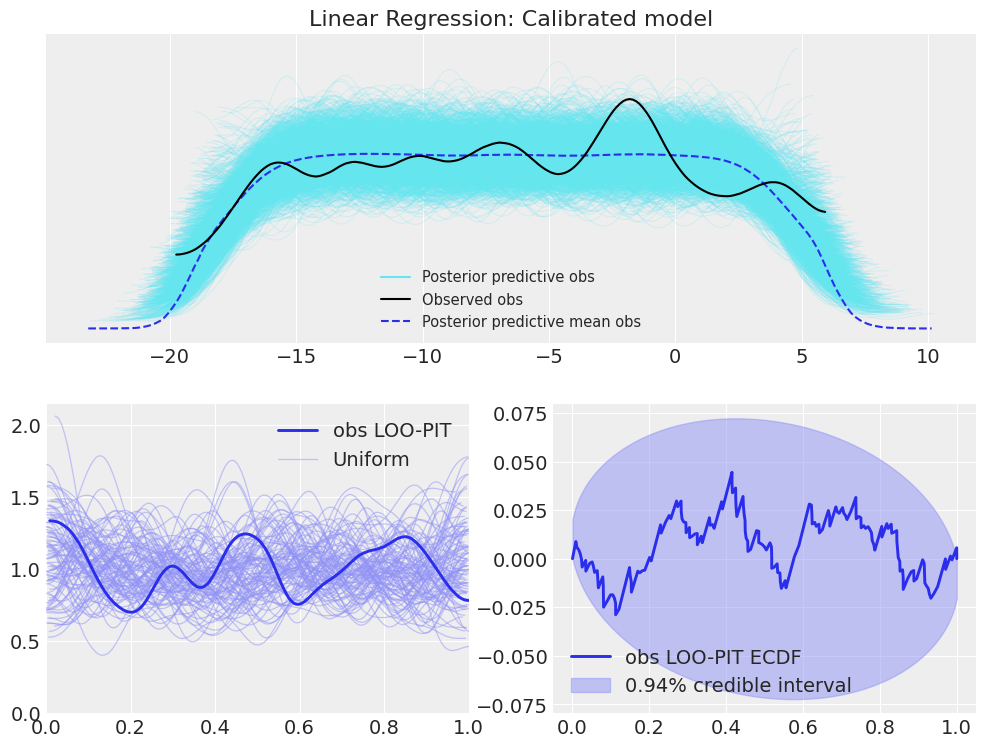

In [16]:
plot_ppc_loopit(idata_lr, "Linear Regression: Calibrated model");

Now let's see how does introducing some small bias modifies the results.

In [17]:
with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', sd=10)
    a1 = pm.Normal("a1", mu=0, sd=20)

    likelihood = pm.Normal('obs', mu=a0_lr + 2 + a1 * data_x_regression, sd=sigma, observed=data_y_regression)

    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    idata_lr_bias = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_regression,
        dims=dims_regression,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5018.12draws/s]
The acceptance probability does not match the target. It is 0.8792817423537712, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:01<00:00, 1413.29it/s]


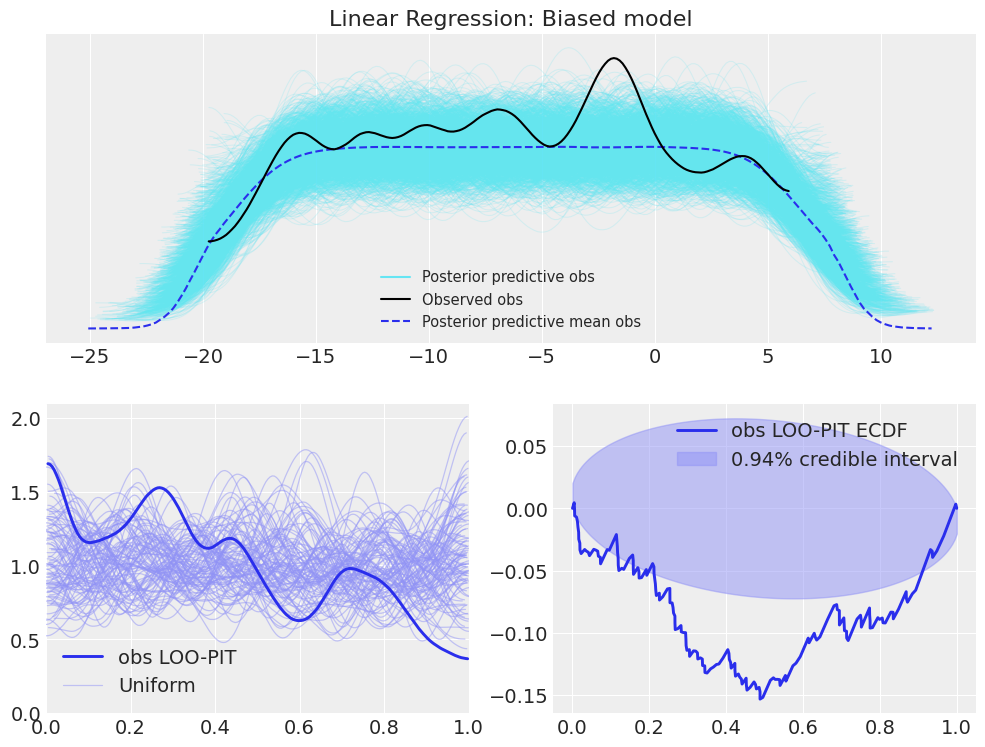

In [18]:
plot_ppc_loopit(idata_lr_bias, "Linear Regression: Biased model");

Now the LOO-PIT check is clearly showing signs of bias in the model, whereas due to the lack of rescaling, no bias is seen in the posterior predictive checks.

Finally, let's combine some bias with overdispersion, to see how is LOO-PIT modified. Moreover, we will rescale the posterior predictive data to see how would rescaling affect the posterior predictive checks.

In [19]:
with pm.Model() as model:
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    likelihood = pm.Normal(
        'obs', mu=a0_lr + 2 + a1 * data_x_regression, sd=1.5 * sd_lr, observed=data_y_regression
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    idata_lr_bias_overdispersed = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords_regression,
        dims=dims_regression,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1]
100%|██████████| 2000/2000 [00:00<00:00, 2138.31it/s]


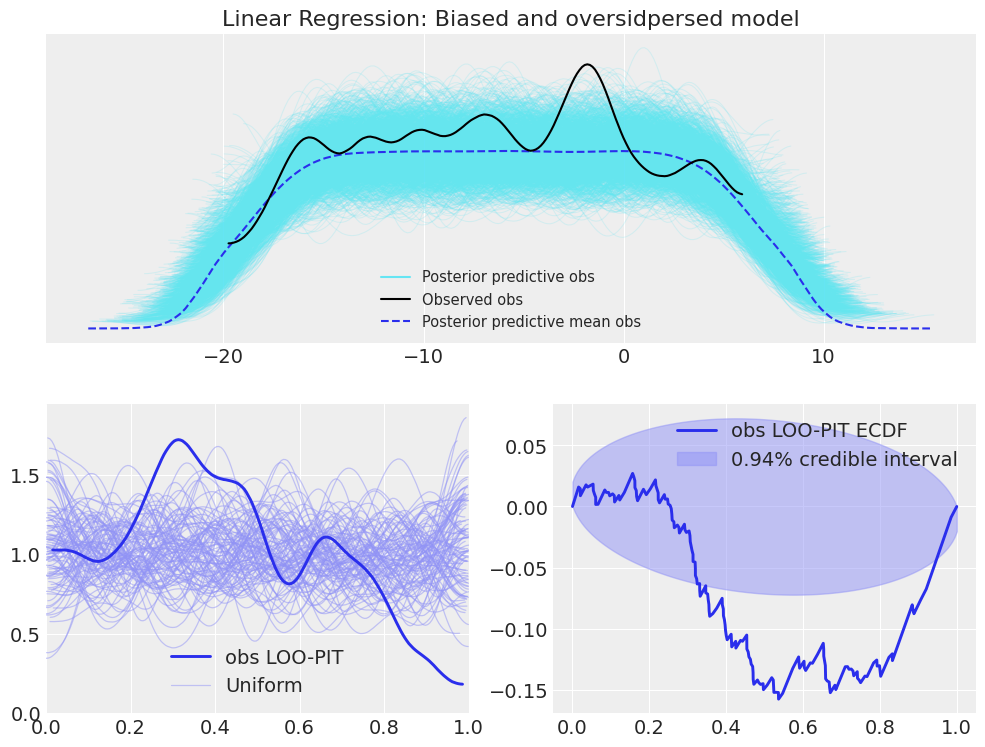

In [20]:
plot_ppc_loopit(idata_lr_bias_overdispersed, "Linear Regression: Biased and oversidpersed model");

In [21]:
pp_samples = idata_lr_bias_overdispersed.posterior_predictive.obs
obs_samples = idata_lr_bias_overdispersed.observed_data.obs
pp_means = pp_samples.mean(dim=("chain", "draw"))
pp_stds = pp_samples.std(dim=("chain", "draw"))
idata_lr_bias_overdispersed.posterior_predictive["obs_rescaled"] = (pp_samples - pp_means) / pp_stds
idata_lr_bias_overdispersed.observed_data["obs_rescaled"] = (obs_samples - pp_means) / pp_stds

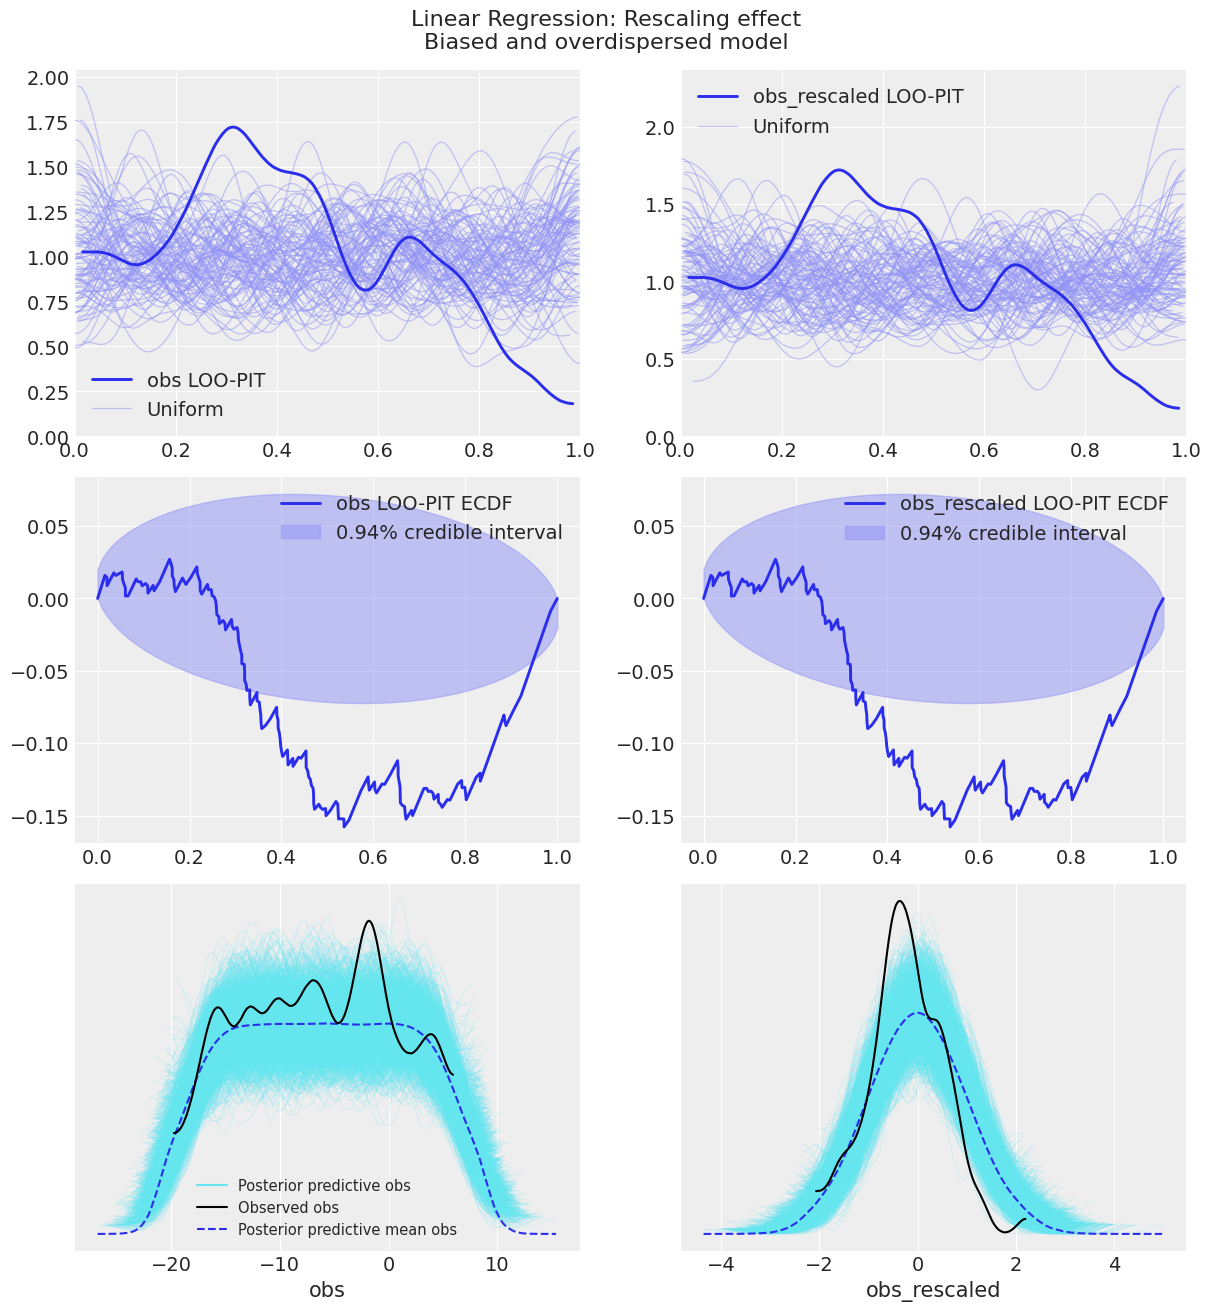

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(12,13), constrained_layout=True)
for i, var in enumerate(("obs", "obs_rescaled")):
    for j, ecdf in enumerate((False, True)):
        az.plot_loo_pit(idata_lr_bias_overdispersed, y=var, ecdf=ecdf, ax=axes[j, i]);
az.plot_ppc(idata_lr_bias_overdispersed, ax=axes[2]);
fig.suptitle("Linear Regression: Rescaling effect\nBiased and overdispersed model", fontsize=16);

As you can see, the posterior predictive check for `obs_rescaled` does indicate overdispersion and bias of the posterior predictive samples, whereas the one for `obs` does not, following what we were seeing previously. The LOO-PIT checks do not change one bit however. This is actually a property of the LOO-PIT algorithm. As it is comparing the marginal distributions of the posterior predictive and the observed data using the MCMC samples, any _monotonous_ transformation will not modify its value because it won't modify the order between the samples. Therefore, if the observed data is larger than 36% of the posterior predictive samples, the rescaling we have done does not modify this fact.

---
Comments are not enabled for the blog, to inquiry further about the contents of the post, ask on [ArviZ Issues](https://github.com/arviz-devs/arviz/issues) or [PyMC3 Discourse](https://discourse.pymc.io/)